In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from utils import niceprint, nicesubplots, without_diag, bfs_layout

In [2]:
np.random.seed(1)

In [3]:
def make_dag(layers):
    g = nx.DiGraph()
    g.add_node(0)
    num_nodes = 1
    num_nodes_prev = 0
    for i, layer_size in enumerate(layers):
        if i == 0:
            for b in range(layer_size):
                g.add_edge(0, 1+b)
        else:
            prev_layer_size = layers[i - 1]
            for a in range(prev_layer_size):
                for b in range(layer_size):
                    g.add_edge(num_nodes_prev+a, num_nodes+b)
        num_nodes_prev = num_nodes
        num_nodes += layer_size
    g.graph["root"] = 0
    return g

In [4]:
def make_tree(branching_factors):
    g = nx.DiGraph()
    g.add_node(0)
    num_nodes = 1
    nodes_prev_layer = [0]
    for i, factor in enumerate(branching_factors):
        nodes_current_layer = []
        for n in nodes_prev_layer:
            for c in range(factor):
                g.add_edge(n, num_nodes)
                nodes_current_layer.append(num_nodes)
                num_nodes += 1
        nodes_prev_layer = nodes_current_layer
    g.graph["root"] = 0
    return g

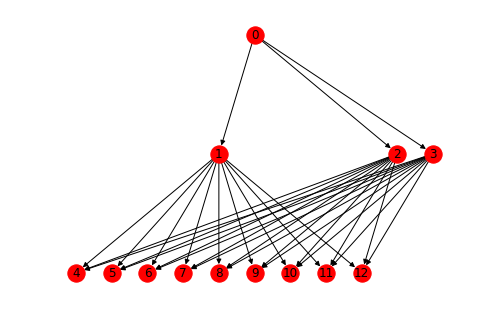

In [5]:
dense_dag = make_dag([3, 9])
nx.draw(dense_dag, pos=bfs_layout(dense_dag), with_labels=True)

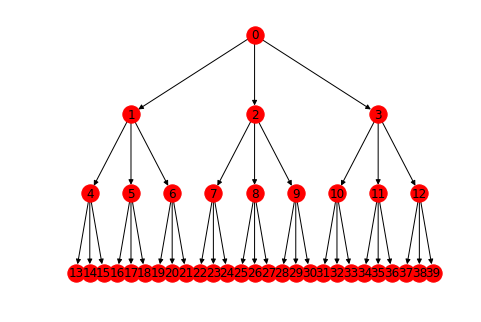

In [6]:
tree = make_tree([3, 3, 3])
nx.draw(tree, pos=bfs_layout(tree), with_labels=True)

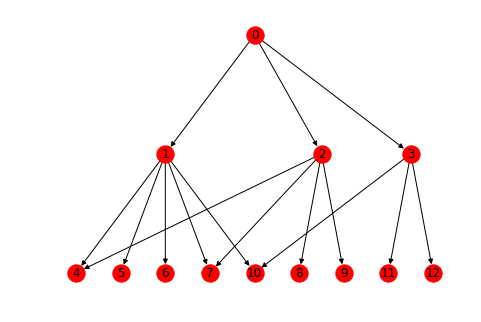

In [7]:
sparse_dag = make_tree([3, 3])
sparse_dag.add_edge(1, 7)
sparse_dag.add_edge(1, 10)
sparse_dag.add_edge(2, 4)
nx.draw(sparse_dag, pos=bfs_layout(sparse_dag), with_labels=True)

In [8]:
graphs = [("Tree", tree), ("DenseDAG", dense_dag), ("SparseDAG", sparse_dag)]

In [9]:
def niceimshow(X, ax = None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(X, **kwargs)
    ax.axis('off')

## Direct computation

Trying to compute pairwise probabilities directly

In [10]:
def get_alpha(num_children, pexit = None, scale = 1.0):
    if pexit is None:
        pexit = 1.0 / (num_children + 1)
    pother = (1 - pexit) / float(num_children)
    result = pother * np.ones(num_children + 1)
    result[0] = pexit
    result *= scale * (num_children + 1)
    return result

In [11]:
alpha = get_alpha(4, pexit = 1/2.)
print(alpha)
print(alpha[0] / sum(alpha))

[2.5   0.625 0.625 0.625 0.625]
0.5


In [12]:
from collections import defaultdict, Counter
from functools import partial
import itertools

In [13]:
def gen_all_paths(g, prefix=None):
    if prefix is None:
        prefix = (g.graph["root"],)
    yield prefix
    for c in g.neighbors(prefix[-1]):
        new_prefix = prefix + (c,)
        for p in gen_all_paths(g, new_prefix):
            yield p

In [14]:
def compute_combo_probability(g, path_combo, alpha_func = None, alpha_mode = None):
    if alpha_func is None:
        alpha_func = get_alpha

    # hPAM2 calculations
    def num_children(node):
        return len(list(g.neighbors(node)))
    def gen_transitions(r):
        assert len(r) > 0
        for i in range(len(r) - 1):
            yield (r[i], r[i + 1])
        if num_children(r[-1]) > 0:
            # Include any non-trivial ending transitions (ie, exiting the DAG before reaching a sink node)
            yield (r[-1], None)
    transitions = defaultdict(Counter)

    for path in path_combo:
        for src, dest in gen_transitions(path):
            transitions[src][dest] += 1
    
    result = 1.0
    for src, dest_counter in transitions.items():
        if alpha_mode is None:
            nc = num_children(src)
            alpha = alpha_func(nc)
        elif alpha_mode == "node_id":
            alpha = alpha_func(src)
        else:
            raise ValueError("Unrecognized alpha_mode: {}".format(alpha_mode))
        alpha_exit, alpha_child = alpha[0], alpha[1]
        denom = 1.0
        for i in range(sum(dest_counter.values())):
            denom *= alpha.sum() + i
        numer = 1.0
        for dest, count in dest_counter.items():
            a = alpha_exit if dest is None else alpha_child
            for i in range(count):
                numer *= a + i
        result *= numer / denom

    return result

In [15]:
def compute_combo_tensor(g, combo_size, alpha_func = None, alpha_mode = None):
    num_nodes = len(g.nodes())
    result = np.zeros(tuple(num_nodes for i in range(combo_size)))
    for combo in itertools.product(gen_all_paths(g), repeat = combo_size):
        coords = tuple(c[-1] for c in combo)
        result[coords] += compute_combo_probability(g, combo, alpha_func = alpha_func, alpha_mode = alpha_mode)
    return result

In [16]:
def tensor_to_matrix(T):
    if np.ndim(T) < 2:
        T = np.atleast_2d(T)
    while np.ndim(T) > 2:
        if np.ndim(T) == 3:
            axis = 0 if T.shape[0] * T.shape[1] < T.shape[1] * T.shape[2] else 1
        else:
            axis = np.argmin(T.shape)
        T = np.concatenate(T, axis=axis)
    return T

In [17]:
R = compute_combo_tensor(tree, 2, alpha_func=partial(get_alpha, pexit=None, scale=1))

In [18]:
R.sum()

1.0000000000000002

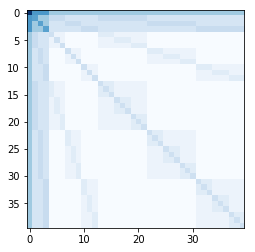

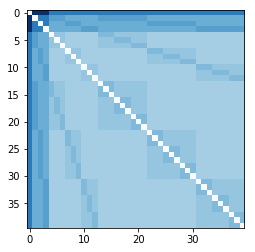

In [19]:
fig, ax = plt.subplots(); ax.imshow(np.power(R, 0.1) , cmap='Blues');
fig, ax = plt.subplots(); ax.imshow(without_diag(np.power(R, 0.25)), cmap='Blues');

## Interactive experiments

In [20]:
import ipywidgets

In [21]:
from collections import OrderedDict

In [22]:
pexit_widget = ipywidgets.FloatSlider(0.5, min=0, max=1, step=0.05)
pexit_widget.layout.display = 'none'

auto_pexit_widget = ipywidgets.Checkbox(True, description="Auto-assign pexit")
def _observe_checkbox(change):
    pexit_widget.layout.display = 'none' if change['new'] else 'flex'
auto_pexit_widget.observe(_observe_checkbox, names='value')

@ipywidgets.interact_manual(
    select_graph = OrderedDict(graphs),
    combo_size = ipywidgets.Dropdown(value = 2, options = [1,2,3]),
    include_diag = [False, True],
    use_conditional = [False, True],
    alpha_scale = ipywidgets.FloatLogSlider(1, min=-2, max=1, step=0.1),
    auto_pexit = auto_pexit_widget,
    pexit = pexit_widget,
)
def _view_results(select_graph, combo_size, include_diag, use_conditional, alpha_scale, auto_pexit, pexit):
    global R, R_plot
    if auto_pexit:
        pexit = None
    R = compute_combo_tensor(select_graph, combo_size, alpha_func=partial(get_alpha, pexit=pexit, scale=alpha_scale))
    if use_conditional:
        R /= R.sum(axis=0)
    R_plot = R if include_diag else without_diag(R)
    R_plot = tensor_to_matrix(R_plot)
    fig, ax = plt.subplots(figsize=(20,4))
    ax.imshow(R_plot, cmap='Blues')
    ax.axis('off')
    ax.set_title("HPAM2")

interactive(children=(Dropdown(description='select_graph', options=OrderedDict([('Tree', <networkx.classes.dig…

Notes:
* Setting `pexit = 0` exactly corresponds to PAM above
* Setting `pexit = 0.423` **approximates** HPAM1 above
* Auto-assigning `pexit` exactly corresponds to HPAM2 above
  * For the Tree case, this corresponds exactly to `pexit = 0.25`
  * For the DAG case, this corresponds approximately to `pexit = 0.178`

The value 0.423 is an approximate minimizer of $\Vert(1/3, 1/3, 1/3) - (p, p(1-p), (1-p)^2)\Vert_1$.
In other words, this is the closest that HPAM2 can get to a uniform probability distribution over depths, which is used in the HPAM1 tests above.

The value 0.178 is an approximate minimizer of $\Vert(1/4, 3/40, 27/40) - (p, p(1-p), (1-p)^2)\Vert_1$.
In other words, this is the closest that a uniform value of `pexit` can get to a depth distribution of $(1/4, 3/40, 27/40)$ -- which is the exact depth distribution that we get from running HPAM2 on the fully-connected DAG and auto-assigning `pexit` on a per-node basis.

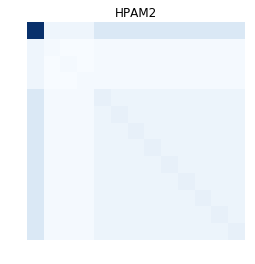

In [23]:
_view_results(
    select_graph=dense_dag,
    combo_size=2,
    include_diag=True,
    use_conditional=False,
    alpha_scale=1.0,
    auto_pexit=True,
    pexit=None,
)

In [24]:
depths = [0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]
prob_by_depth = np.zeros(np.max(depths) + 1)
np.add.at(prob_by_depth, depths, R.sum(axis=0))
prob_by_depth

array([0.25 , 0.075, 0.675])

In [25]:
np.array([1/4., 3/40., 27/40.])

array([0.25 , 0.075, 0.675])

In [26]:
from scipy.optimize import minimize_scalar

In [27]:
f = lambda x: np.array([x, x*(1-x), (1-x)**2])

In [28]:
target = np.array([1/3, 1/3, 1/3])
x = minimize_scalar(lambda x: np.linalg.norm(target - f(x), ord=1)).x
print("target = {}\nx = {} yields f(x) = {}".format(target, x, f(x)))

target = [0.33333333 0.33333333 0.33333333]
x = 0.4226497317237661 yields f(x) = [0.42264973 0.24401694 0.33333333]


In [29]:
target = np.array([1/4, 3/40, 27/40])
x = minimize_scalar(lambda x: np.linalg.norm(target - f(x), ord=1)).x
print("target = {}\nx = {} yields f(x) = {}".format(target, x, f(x)))

target = [0.25  0.075 0.675]
x = 0.17841616540420124 yields f(x) = [0.17841617 0.14658384 0.675     ]


## Tree Extraction

In [30]:
from tree_extraction import GreedyNoStructure, GreedyWithStructure, GreedyThreshold

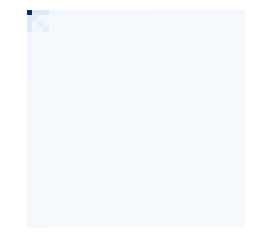

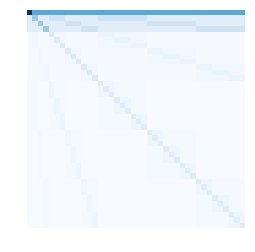

In [31]:
R = compute_combo_tensor(tree, combo_size = 2, alpha_func=partial(get_alpha, pexit=0.3, scale=1.0))
niceimshow(R, cmap='Blues');
niceimshow(R / R.sum(axis=0), cmap='Blues')

In [32]:
diagnostics = []
t1 = GreedyNoStructure.extract(R, apply_cond = True, diagnostics = diagnostics)

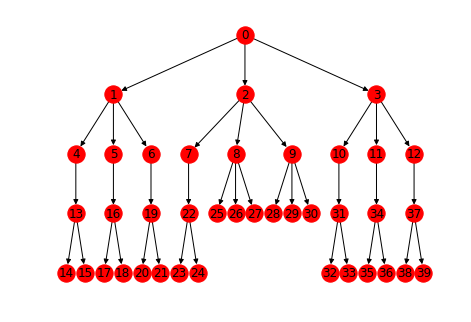

In [33]:
nx.draw(t1, pos=bfs_layout(t1), with_labels=True)

In [34]:
if len(diagnostics) <= 10:
    GreedyNoStructure.display_diagnostics(diagnostics)
else:
    print("Skipping diagnostics")

Skipping diagnostics


In [35]:
try:
    t2 = GreedyWithStructure.extract(R, branching_factors=[3,3,3])
except AssertionError:
    t2 = None

In [36]:
if t2 is not None:
    nx.draw(t2, pos=bfs_layout(t2), with_labels=True)

In [37]:
t3 = GreedyThreshold.extract(R, threshold = 0.1, apply_cond = True)

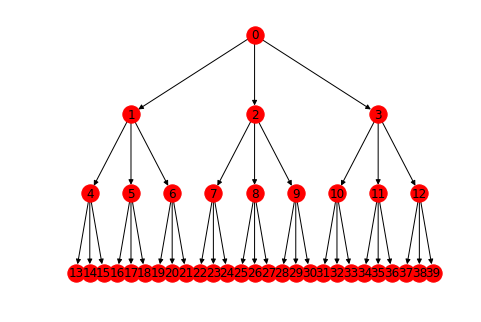

In [38]:
nx.draw(t3, pos=bfs_layout(t3), with_labels=True)

In [39]:
expected = {node: set(tree.neighbors(node)) for node in tree.nodes()}

In [40]:
def graph_diff(g, expected):
    result = {}
    all_nodes = set(g.nodes())
    for node in all_nodes:
        children_seen = set(g.neighbors(node))
        children_expected = set(expected.get(node, set()))
        if children_seen != children_expected:
            result[node] = {
                "actual": children_seen,
                "expected": children_expected,
            }
    for node in expected:
        if node not in all_nodes:
            result[node] = {
                "actual": set(),
                "expected": expected[node],
            }
    return result

In [41]:
graph_diff(tree, expected)

{}

In [42]:
graph_diff(t1, expected)

{4: {'actual': {13}, 'expected': {13, 14, 15}},
 5: {'actual': {16}, 'expected': {16, 17, 18}},
 6: {'actual': {19}, 'expected': {19, 20, 21}},
 7: {'actual': {22}, 'expected': {22, 23, 24}},
 10: {'actual': {31}, 'expected': {31, 32, 33}},
 11: {'actual': {34}, 'expected': {34, 35, 36}},
 12: {'actual': {37}, 'expected': {37, 38, 39}},
 13: {'actual': {14, 15}, 'expected': set()},
 16: {'actual': {17, 18}, 'expected': set()},
 19: {'actual': {20, 21}, 'expected': set()},
 22: {'actual': {23, 24}, 'expected': set()},
 31: {'actual': {32, 33}, 'expected': set()},
 34: {'actual': {35, 36}, 'expected': set()},
 37: {'actual': {38, 39}, 'expected': set()}}

In [43]:
if t2 is not None:
    graph_diff(t2, expected)

In [44]:
graph_diff(t3, expected)

{}

## Tree relation utilities

In [45]:
def get_tree_relation(p1, p2, symmetric = True):
    c = d1 = d2 = dS = dL = 0
    for i in range(max(len(p1), len(p2))):
        found_diff = False
        if i >= len(p1):
            found_diff = True
            d2 += 1
            dL += 1
        elif i >= len(p2):
            found_diff = True
            d1 += 1
            dL += 1  # Note: dL may correspond to p1 or p2, whichever is longer
        elif found_diff or p1[i] != p2[i]:
            found_diff = True
            d1 += 1
            d2 += 1
            dS += 1
            dL += 1
        else:
            c += 1
    if dS == 0 and dL == 0:
        dt = 'self'
    elif dS == 0 and dL == 1:
        if symmetric or d1 < d2:
            dt = 'parent'
        else:
            dt = 'child'
    elif dS == 0 and dL >= 2:
        if symmetric or d1 < d2:
            dt = 'grandparent'
        else:
            dt = 'grandchild'
        dt = ('great-' * (dL - 2)) + dt
    elif dS == 1 and dL == 1:
        dt = 'sibling'
    elif dS == 1 and dL >= 2:
        if symmetric or d1 < d2:
            dt = 'aunt'
        else:
            dt = 'niece'
        dt = ('great-' * (dL - 2)) + dt
    elif dS == 2 and dL == 2:
        dt = 'cousin'
    elif dS >= 3 and dL == dS:
        dt = 'cousin-' + str(dL - 1)
    else:
        dt = 'other'
    return dt, c, d1, d2

In [46]:
def get_tree_paths(tree):
    return {k: v[1:] for k, v in nx.algorithms.shortest_path(tree, source = 0).items()}

## "Conditional" matrix

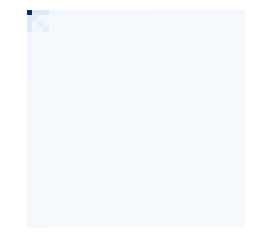

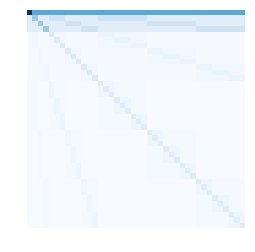

In [47]:
R = compute_combo_tensor(tree, combo_size = 2, alpha_func=partial(get_alpha, pexit=0.3, scale=1.0))
niceimshow(R, cmap='Blues');
niceimshow(R / R.sum(axis=0), cmap='Blues')

## "Difference" or "Covariance" Matrix (?)

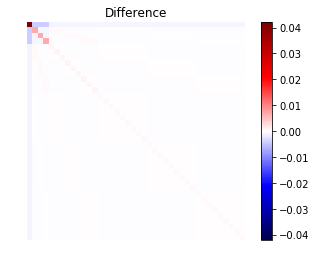

In [48]:
# Convert co-occurrence --> covariance
R = compute_combo_tensor(tree, combo_size = 2, alpha_func=partial(get_alpha, pexit=0.3, scale=1.0))
p_node = R.sum(axis=0)
C = R - np.outer(p_node, p_node)
vmax = np.max(np.abs(C))
niceimshow(C, cmap='seismic', vmin=-vmax, vmax=vmax)
plt.gca().set_title("Difference")
plt.colorbar(plt.gca().images[0]);

## Ratio matrix

In [91]:
def get_ratio_matrix(R):
    p_node = R.sum(axis = 0)
    return R / np.outer(p_node, p_node)

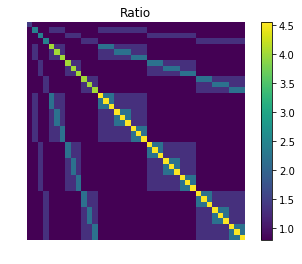

In [92]:
R = compute_combo_tensor(tree, combo_size = 2, alpha_func=partial(get_alpha, pexit=0.3, scale=1.0))
C = get_ratio_matrix(R)
#vmax = np.max(np.abs(C))
#niceimshow(C, cmap='seismic', vmin=-vmax, vmax=vmax)
niceimshow(C)
plt.gca().set_title("Ratio")
plt.colorbar(plt.gca().images[0]);

In [93]:
eps = 0.001
C_thresh = (without_diag(C) > (1 - eps) * np.max(without_diag(C), axis=1, keepdims=True)).astype('int')

In [94]:
paths = get_tree_paths(tree)
[(n1, n2, paths[n1], paths[n2], get_tree_relation(paths[n1], paths[n2], symmetric = False)[0]) for n1, n2 in zip(*np.where(C_thresh))]

[(0, 1, [], [1], 'parent'),
 (0, 2, [], [2], 'parent'),
 (0, 3, [], [3], 'parent'),
 (0, 4, [], [1, 4], 'grandparent'),
 (0, 5, [], [1, 5], 'grandparent'),
 (0, 6, [], [1, 6], 'grandparent'),
 (0, 7, [], [2, 7], 'grandparent'),
 (0, 8, [], [2, 8], 'grandparent'),
 (0, 9, [], [2, 9], 'grandparent'),
 (0, 10, [], [3, 10], 'grandparent'),
 (0, 11, [], [3, 11], 'grandparent'),
 (0, 12, [], [3, 12], 'grandparent'),
 (0, 13, [], [1, 4, 13], 'great-grandparent'),
 (0, 14, [], [1, 4, 14], 'great-grandparent'),
 (0, 15, [], [1, 4, 15], 'great-grandparent'),
 (0, 16, [], [1, 5, 16], 'great-grandparent'),
 (0, 17, [], [1, 5, 17], 'great-grandparent'),
 (0, 18, [], [1, 5, 18], 'great-grandparent'),
 (0, 19, [], [1, 6, 19], 'great-grandparent'),
 (0, 20, [], [1, 6, 20], 'great-grandparent'),
 (0, 21, [], [1, 6, 21], 'great-grandparent'),
 (0, 22, [], [2, 7, 22], 'great-grandparent'),
 (0, 23, [], [2, 7, 23], 'great-grandparent'),
 (0, 24, [], [2, 7, 24], 'great-grandparent'),
 (0, 25, [], [2, 8, 25

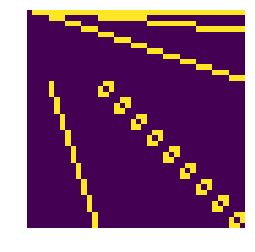

In [95]:
niceimshow(C_thresh)

In [96]:
def permute_square(X, perm):
    perm = np.reshape(perm, (-1, 1))
    return X[perm, perm.T]

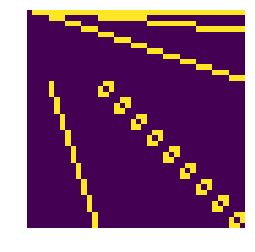

In [97]:
perm = np.arange(C.shape[0])
perm[4], perm[13] = 13, 4
C_thresh_perm = permute_square(C_thresh, perm)
niceimshow(C_thresh_perm)

In [102]:
# TODO: check this algorithm
def triplets(C):
    result = set()
    for i in range(C.shape[0]):
        for j in range(i):
            for k in range(C.shape[0]):
                if k == i or k == j:
                    continue
                if C[i,j] > C[i,k] and C[i,j] > C[j,k]:
                    triplet = (i, j, k)
                    result.add(triplet)
    return result

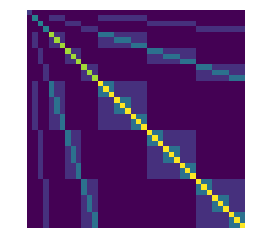

In [103]:
niceimshow(C)

In [104]:
C.shape[0] ** 3

64000

In [105]:
len(triplets(C))

8523

In [106]:
def niceprint_str_graph(g):
    result = "nodes: {}".format(list(g.nodes()))
    if "root" in g.graph:
        result += ", root: {}".format(g.graph["root"])
    result += ", edges: [{}]".format(", ".join(["{} <-> {}".format(a, b) for a, b in g.edges()]))
    return result

def niceprint_graph(g):
    print(niceprint_str_graph(g))

In [107]:
def aho_tree_build(nodes, constraints):
    # Use list of triplet constraints of the form ({a,b},c); ie, LCA(a,b) < LCA(a,c)
    # to build a tree via Aho et al's algorithm
    if isinstance(nodes, set):
        nodes = list(nodes)
    
    if len(nodes) == 1:
        result = nx.Graph()
        result.add_node(nodes[0])
        result.graph["root"] = nodes[0]
        return result
    
    graph = nx.Graph()
    for n in nodes:
        graph.add_node(n)
    for c in constraints:
        graph.add_edge(c[0], c[1])
    components = list(nx.algorithms.connected_components(graph))
    
    if len(components) == 1:
        return None

    subtrees = []
    cumulative_internal = 0
    for S in components:
        C = [(i,j,k) for i,j,k in constraints if i in S and j in S and k in S]
        T = aho_tree_build(S, C)
        if T is None:
            return None
        subtrees.append((T, cumulative_internal))

        num_internal = len(list(T.nodes())) - len(S)
        cumulative_internal += num_internal

    new_root = ("internal", cumulative_internal)
    result = nx.Graph()
    result.add_node(new_root)
    result.graph["root"] = new_root
    for T, offset in subtrees:
        mapper = dict()
        for n in T.nodes():
            if isinstance(n, tuple) and n[0] == "internal":
                nprime = ("internal", n[1] + offset)
            else:
                nprime = n
            mapper[n] = nprime
            result.add_node(nprime)
        for a, b in T.edges():
            result.add_edge(mapper[a], mapper[b])
        result.add_edge(new_root, mapper[T.graph["root"]])
    return result

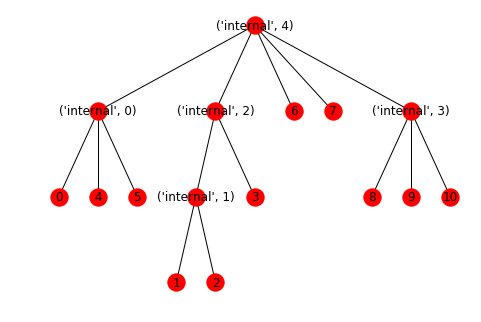

In [108]:
# Test basic case of Aho's tree-building algorithm
g = aho_tree_build(np.arange(11), [(1,2,3),(2,3,4),(4,5,1),(8,9,6),(9,10,6),(0,4,6)])
nx.draw(g, pos=bfs_layout(g), with_labels=True)

[12  3 12  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3 12  3 39  3  3  3  3  3  3  3]


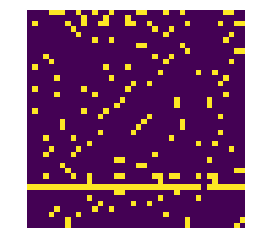

In [63]:
np.random.seed(1)
perm = np.random.permutation(C_thresh.shape[0])
C_thresh_perm = permute_square(C_thresh, perm)
niceimshow(C_thresh_perm)
print(C_thresh_perm.sum(axis=1))

In [64]:
def check_ratio_matrix(tree, C, verbose = False, atol = 1e-10):
    paths = get_tree_paths(tree)
    
    leaf1 = C.shape[0] - 2
    leaf2 = C.shape[0] - 1
    parent = paths[leaf1][-2]
    internal = list(tree.neighbors(tree.graph['root']))[0]
    child = list(tree.neighbors(internal))[0]

    # Check whether C(leaf1, leaf2) = C(leaf1, parent(leaf1))
    assert np.isclose(C[leaf1, leaf2], C[leaf1, parent], atol=atol), "Failed at leaf-vs-parent case"
    if verbose: print("1.a. Successfully checked leaf-vs-parent case")

    # Check whether C(leaf1, leaf2) > C(leaf1, other)
    # for any value of `other` that is not equal to, or a descendant of, parent(leaf1)
    num_checked = 0
    for node in range(C.shape[0]):
        if parent in paths[node]:
            continue
        assert C[leaf1, leaf2] > atol + C[leaf1, node], "Failed at node {}".format(node)
        num_checked += 1
    if verbose: print("1.b. Successfully checked {} nodes".format(num_checked))

    # Check whether C(internal, d1) = C(internal, d2)
    # for all d1, d2 in descendants(internal)
    num_checked = 0
    for node in range(C.shape[0]):
        p = paths[node]
        if len(p) == 0 or node == internal or internal not in p:
            continue
        assert np.isclose(C[internal, child], C[internal, node], atol=atol), "Failed at node {}".format(node)
        num_checked += 1
    if verbose: print("2.a. Successfully checked {} descendants".format(num_checked))

    # Check whether C(internal, d1) > C(internal, other)
    # for any value of `other` that is not equal to, or a descendant of, `internal`
    num_checked = 0
    for node in range(C.shape[0]):
        p = paths[node]
        if internal in p:
            continue
        assert C[internal, child] > atol + C[internal, node], "Failed at node {}".format(node)
        num_checked += 1
    if verbose: print("2.b. Successfully checked {} non-descendants".format(num_checked))

In [65]:
check_ratio_matrix(tree, C, verbose=True)

1.a. Successfully checked leaf-vs-parent case
1.b. Successfully checked 36 nodes
2.a. Successfully checked 12 descendants
2.b. Successfully checked 27 non-descendants


In [66]:
%%time

pexit_list = [0.001, 0.2, 0.25, 0.3, 0.5, 0.6, 0.999]
scale_list = [0.1, 1.0, 10.0]

num_checked = 0
for pexit in pexit_list:
    for scale in scale_list:
        R = compute_combo_tensor(tree, combo_size = 2, alpha_func=partial(get_alpha, pexit=pexit, scale=scale))
        C = get_ratio_matrix(R)
        check_ratio_matrix(tree, C)
        num_checked += 1

print("Successfully checked {} combinations".format(num_checked))

Successfully checked 21 combinations
CPU times: user 3.51 s, sys: 23.3 ms, total: 3.53 s
Wall time: 3.58 s


In [67]:
alt_tree = make_tree([2, 2, 2, 2])
R = compute_combo_tensor(alt_tree, combo_size = 2, alpha_func=partial(get_alpha, pexit=0.5, scale=1000.0))
C = get_ratio_matrix(R)
check_ratio_matrix(alt_tree, C, verbose=True)

1.a. Successfully checked leaf-vs-parent case
1.b. Successfully checked 28 nodes
2.a. Successfully checked 14 descendants
2.b. Successfully checked 16 non-descendants


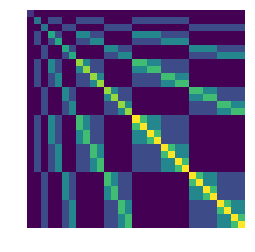

In [68]:
niceimshow(C);

1.a. Successfully checked leaf-vs-parent case
1.b. Successfully checked 4 nodes
2.a. Successfully checked 2 descendants
Assertion failed: Failed at node 0


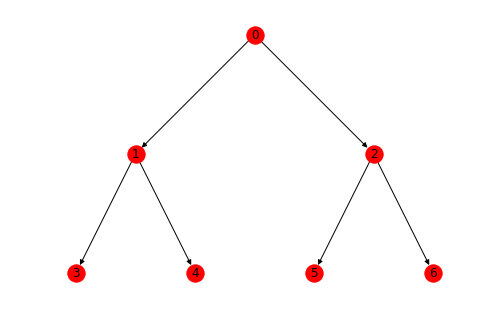

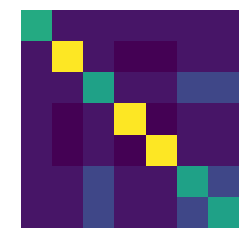

In [69]:
# Counterexample
alt_tree = make_tree([2, 2])
nx.draw(alt_tree, pos = bfs_layout(alt_tree), with_labels = True)

def alt_alpha(node_id):
    if node_id == 0:
        return np.array([1.0, 2.0, 3.0])
    elif node_id == 1:
        return 0.5 * np.ones(3)  # Key characteristic: is sum of this vector > 2?
    elif node_id == 2:
        return 2.0 * np.ones(3)  # Key characteristic: is sum of this vector > 3?

R = compute_combo_tensor(alt_tree, combo_size = 2, alpha_func = alt_alpha, alpha_mode = "node_id")
C = get_ratio_matrix(R)

niceimshow(C);

try:
    check_ratio_matrix(alt_tree, C, verbose=True)
except AssertionError as e:
    print("Assertion failed: {}".format(e))
else:
    print("Assertion succeeded")

## Permutations of nodes

Here's a problem: if we swap some children & grandchildren for certain $R$ matrices, we get exactly the same matrix

In [70]:
tree_small = make_tree([3,3])

In [71]:
R = compute_combo_tensor(tree_small, combo_size = 2, alpha_func=partial(get_alpha, pexit=0.25, scale=1.0))

In [72]:
# Swap some children & grandchildren
R2 = permute_square(R, [0,  # root
                        4,         9,         11,          # first layer
                        1, 5, 6,   7, 8, 2,   3, 10, 12,  # second layer
                        *np.arange(13, R.shape[0])])

In [73]:
niceprint(R - R2)
np.allclose(R, R2)

[[0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.

True

## Unique values in $R$ matrix

Examine the pattern of unique values appearing in $R$

In [74]:
R = compute_combo_tensor(tree, combo_size = 2, alpha_func=partial(get_alpha, pexit=0.25, scale=1.0))

In [75]:
unique_vals = np.unique(R.flatten())
unique_vals

array([0.00019531, 0.0003125 , 0.0005    , 0.00078125, 0.001     ,
       0.00125   , 0.003125  , 0.01      , 0.0125    , 0.1       ])

In [76]:
R_unique_indices = np.vectorize(lambda x: np.where(x == unique_vals)[0])(R)
niceprint(R_unique_indices)

[[9 8 8 8 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
 [8 7 6 6 5 5 5 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [8 6 7 6 3 3 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 3 3 3 3 3 3 3 3 3]
 [8 6 6 7 3 3 3 3 3 3 5 5 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5]
 [6 5 3 3 4 1 1 0 0 0 0 0 0 2 2 2 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [6 5 3 3 1 4 1 0 0 0 0 0 0 1 1 1 2 2 2 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [6 5 3 3 1 1 4 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [6 3 5 3 0 0 0 4 1 1 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [6 3 5 3 0 0 0 1 4 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 1 1 1 0 0 0 0 0 0 0 0 0]
 [6 3 5 3 0 0 0 1 1 4 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 0 0 0 0 0 0 0 0 0]
 [6 3 3 5 0 0 0 0 0 0 4 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 1 1 1 1 1 1]
 [6 3 3 5 0 0 0 0 0 0 1 4 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 1 1 1]
 [6 

In [77]:
paths = get_tree_paths(tree)
paths

{0: [],
 1: [1],
 2: [2],
 3: [3],
 4: [1, 4],
 5: [1, 5],
 6: [1, 6],
 7: [2, 7],
 8: [2, 8],
 9: [2, 9],
 10: [3, 10],
 11: [3, 11],
 12: [3, 12],
 13: [1, 4, 13],
 14: [1, 4, 14],
 15: [1, 4, 15],
 16: [1, 5, 16],
 17: [1, 5, 17],
 18: [1, 5, 18],
 19: [1, 6, 19],
 20: [1, 6, 20],
 21: [1, 6, 21],
 22: [2, 7, 22],
 23: [2, 7, 23],
 24: [2, 7, 24],
 25: [2, 8, 25],
 26: [2, 8, 26],
 27: [2, 8, 27],
 28: [2, 9, 28],
 29: [2, 9, 29],
 30: [2, 9, 30],
 31: [3, 10, 31],
 32: [3, 10, 32],
 33: [3, 10, 33],
 34: [3, 11, 34],
 35: [3, 11, 35],
 36: [3, 11, 36],
 37: [3, 12, 37],
 38: [3, 12, 38],
 39: [3, 12, 39]}

In [78]:
diff_types = defaultdict(set)
for k1, v1 in paths.items():
    for k2, v2 in paths.items():
        dt, c, d1, d2 = get_tree_relation(v1, v2)
        dt += "({},{},{})".format(c, d1, d2)
        diff_types[dt].add(R[k1, k2])

vals_to_difftypes = defaultdict(set)
for k in diff_types:
    newval = np.asarray(sorted(list(diff_types[k])))
    diff_types[k] = newval
    if len(newval) > 1:
        print("Warning: more than 1 value for difftype {}: {}".format(k, newval))
    for v in newval:
        vals_to_difftypes[v].add(k)

for k in vals_to_difftypes:
    newval = sorted(list(vals_to_difftypes[k]))
    vals_to_difftypes[k] = newval
    if len(newval) > 1:
        print("Note: value {} appears in more than one difftype: {}".format(k, newval))

Note: value 0.0125 appears in more than one difftype: ['parent(0,0,1)', 'parent(0,1,0)']
Note: value 0.003125 appears in more than one difftype: ['grandparent(0,0,2)', 'grandparent(0,2,0)', 'great-grandparent(0,0,3)', 'great-grandparent(0,3,0)', 'sibling(0,1,1)']
Note: value 0.0012500000000000002 appears in more than one difftype: ['grandparent(1,0,2)', 'grandparent(1,2,0)', 'parent(1,0,1)', 'parent(1,1,0)']
Note: value 0.00078125 appears in more than one difftype: ['aunt(0,1,2)', 'aunt(0,2,1)', 'great-aunt(0,1,3)', 'great-aunt(0,3,1)']
Note: value 0.0010000000000000002 appears in more than one difftype: ['self(2,0,0)', 'self(3,0,0)']
Note: value 0.00031250000000000006 appears in more than one difftype: ['aunt(1,1,2)', 'aunt(1,2,1)', 'cousin(1,2,2)', 'sibling(1,1,1)']
Note: value 0.0001953125 appears in more than one difftype: ['cousin(0,2,2)', 'cousin-2(0,3,3)', 'other(0,2,3)', 'other(0,3,2)']
Note: value 0.0005000000000000001 appears in more than one difftype: ['parent(2,0,1)', 'pare

In [79]:
for i, v in enumerate(unique_vals):
    print("({}) {:.4f}: {}".format(i, v, ', '.join(vals_to_difftypes[v])))

(0) 0.0002: cousin(0,2,2), cousin-2(0,3,3), other(0,2,3), other(0,3,2)
(1) 0.0003: aunt(1,1,2), aunt(1,2,1), cousin(1,2,2), sibling(1,1,1)
(2) 0.0005: parent(2,0,1), parent(2,1,0), sibling(2,1,1)
(3) 0.0008: aunt(0,1,2), aunt(0,2,1), great-aunt(0,1,3), great-aunt(0,3,1)
(4) 0.0010: self(2,0,0), self(3,0,0)
(5) 0.0013: grandparent(1,0,2), grandparent(1,2,0), parent(1,0,1), parent(1,1,0)
(6) 0.0031: grandparent(0,0,2), grandparent(0,2,0), great-grandparent(0,0,3), great-grandparent(0,3,0), sibling(0,1,1)
(7) 0.0100: self(1,0,0)
(8) 0.0125: parent(0,0,1), parent(0,1,0)
(9) 0.1000: self(0,0,0)


In [80]:
R.sum(axis=0)

array([0.25    , 0.0625  , 0.0625  , 0.0625  , 0.015625, 0.015625,
       0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625,
       0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625,
       0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625,
       0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625,
       0.015625, 0.015625, 0.015625, 0.015625, 0.015625, 0.015625,
       0.015625, 0.015625, 0.015625, 0.015625])